#Setup

Librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Introducción a los datos
El objetivo del presente dataset es demostrar que existe un cierto patrón en el espectro celeste; es decir, mediante unas determinadas propiedades de las estrellas, saber clasificar de qué tipo son. A continuación detallamos brevemente la información que contienen los datos:

* Temperatura absoluta (en K)
* Luminosidad relativa (L/L0) (Lo = 3.828 x 10^26 Watts)
* Radio relativo (R/R0) (Ro = 6.9551 x 10^8 m)
* Magnitud absoluta (Mv)
* Color de la estrella
* Clase espectral
* Tipo de estrella

Esta idea viene sustentada por el popular diagrama de Hertzsprung-Russell (diagrama HR). 



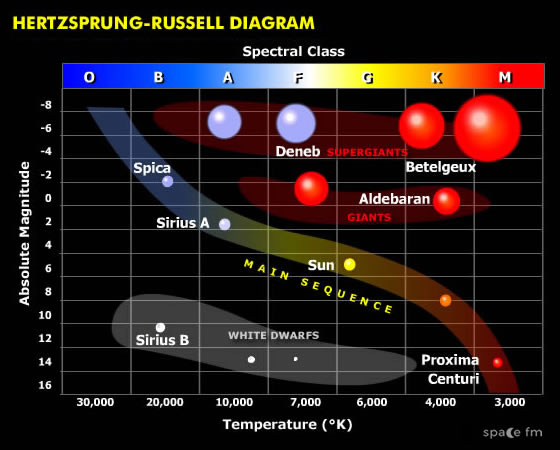

# Exploratory Data Analysis

El primer paso es fijar una ruta de trabajo y leer los datos de la misma

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/EDA/6 class csv.csv') #Leemos los datos

Existen múltiples métodos de *pandas* para ofrecer información sobre los datos. El más genérico es *.info()*, y uno más detallado para variables numéricas es *.describe()*:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


In [7]:
data.select_dtypes(exclude = 'object').describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Analicemos la distribución de elementos de nuestra variable respuesta:

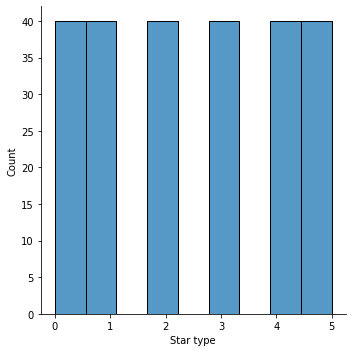

In [8]:
sns.displot(data['Star type'])

El diagrama HR nos muestra, entre otras cosas, que la clase espectral de una estrella está muy estrechamente vinculada con la temperatura de la misma, por lo cual debemos hacer un mapeo manual de dicha variable y no conformarnos con un *LabelEncoder()* para respetar dicha relación:

In [9]:
data['Spectral Class'] = data['Spectral Class'].map({'O': 0, 'B': 1, 'A': 2, 'F': 3, 'G': 4, 'K': 5, 'M': 6})

Tratemos de reproducir con nuestros datos el mencionado diagrama HR, teniendo en cuenta que debemos invertir el orden de ambos ejes:

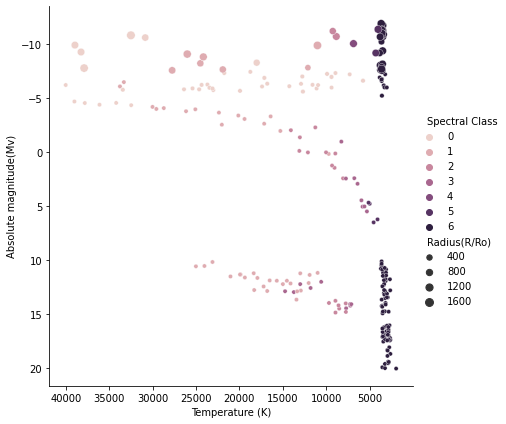

In [10]:
g = sns.relplot(data = data, x = 'Temperature (K)', y = 'Absolute magnitude(Mv)', hue = 'Spectral Class', size = 'Radius(R/Ro)', height = 6)
g.fig.axes[0].invert_yaxis()
g.fig.axes[0].invert_xaxis()
plt.show()

Estudiemos ahora la correlación de nuestras variables:

In [11]:
data.corr(method = 'pearson').sort_values(by = 'Star type', axis = 0).sort_values(by = 'Star type', axis = 1)

,Absolute magnitude(Mv),Spectral Class,Temperature (K),Radius(R/Ro),Luminosity(L/Lo),Star type
Absolute magnitude(Mv),1.000000,0.415359,-0.420261,-0.608728,-0.692619,-0.955276
Spectral Class,0.415359,1.000000,-0.817444,0.060728,-0.346568,-0.461116
Temperature (K),-0.420261,-0.817444,1.000000,0.064216,0.393404,0.411129
Radius(R/Ro),-0.608728,0.060728,0.064216,1.000000,0.526516,0.660975
Luminosity(L/Lo),-0.692619,-0.346568,0.393404,0.526516,1.000000,0.676845
Star type,-0.955276,-0.461116,0.411129,0.660975,0.676845,1.000000


Como hemos mencionado antes, vemos que entre la clase espectral y la temperatura existe una muy alta correlación (-0.817), además del tipo de estrella con la magnitud absoluta:

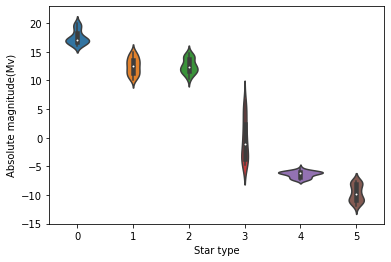

In [12]:
sns.violinplot(data = data, x = 'Star type', y = 'Absolute magnitude(Mv)')

Analizaremos además la simetría de las variables de entrada del modelo, por si precisasen de alguna adaptación previa al modelo:

In [13]:
from scipy import stats
numeric_vars = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
# Check the skew of all numerical features
skewed_feats = data.loc[:,numeric_vars].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness.head())

                            Skew
Luminosity(L/Lo)        2.055121
Radius(R/Ro)            1.934612
Temperature (K)         1.313294
Absolute magnitude(Mv) -0.120779


Vemos que algunas son susceptibles de realizar una transformación Box-Cox:

In [14]:
from scipy.special import boxcox1p #Librería
skewness = skewness.loc[abs(skewness.Skew) > 0.75,:] #Filtramos los que tengan un índice superior a .75
lambda_values = pd.Series(np.linspace(-2,2,40)) #Asignamos candidatos a índices de transformación
for var in skewness.index:
  skews = [stats.skew(boxcox1p(data[var], lam)) for lam in lambda_values]
  lam = lambda_values[pd.Series(np.abs(skews)).idxmin()] #Elegimos el índice óptimo
  data[var] = boxcox1p(data[var], lam)

Podemos visualizar de forma general la distribución del dataset con el siguiente comando:

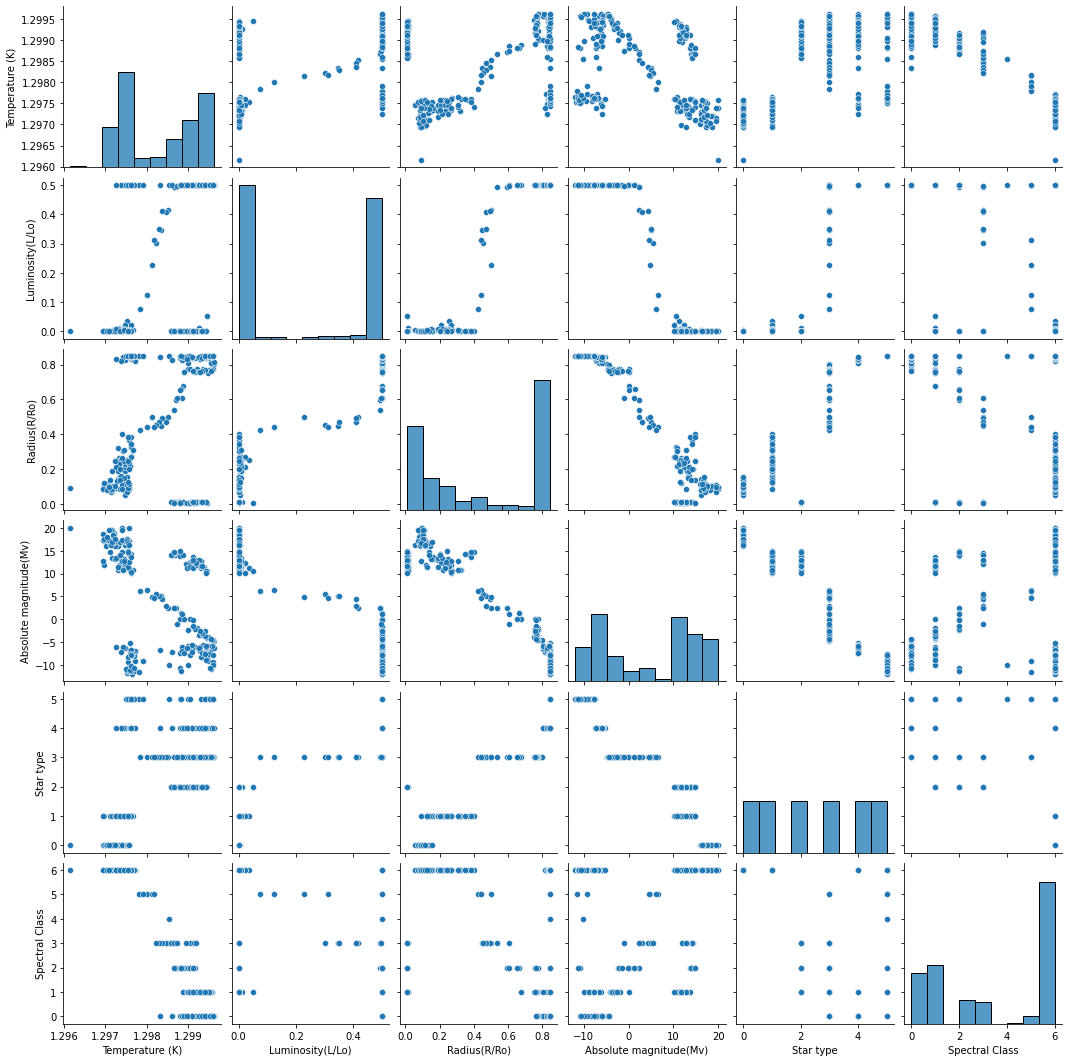

In [15]:
sns.pairplot(data)

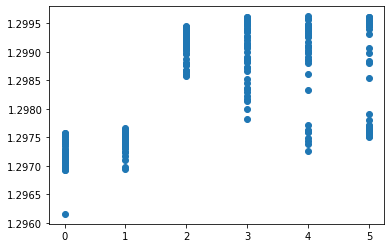

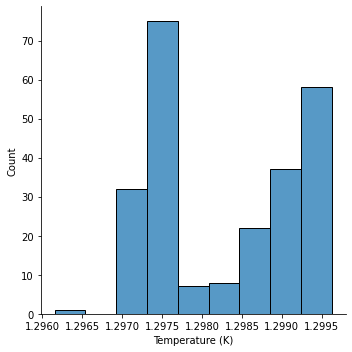

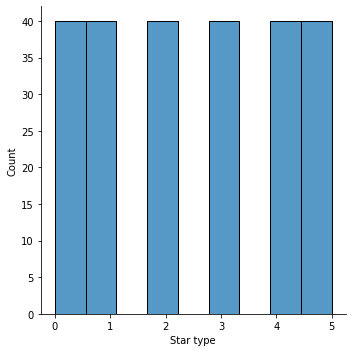

In [30]:
x=data['Star type']
y=data['Temperature (K)']
plt.scatter(x,y)
plt.show()
sns.displot(data['Temperature (K)'])
sns.displot(data['Star type'])

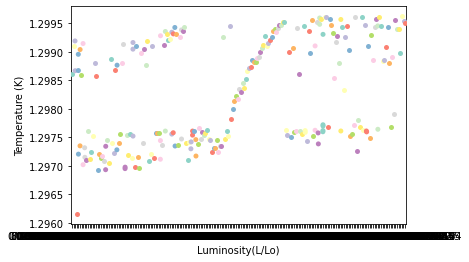

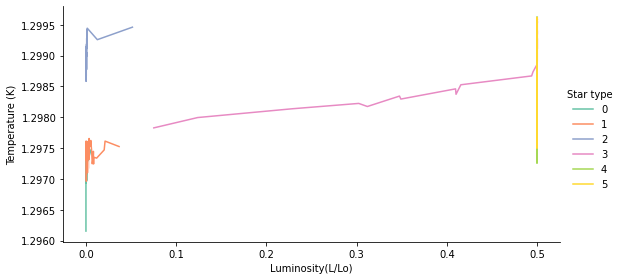

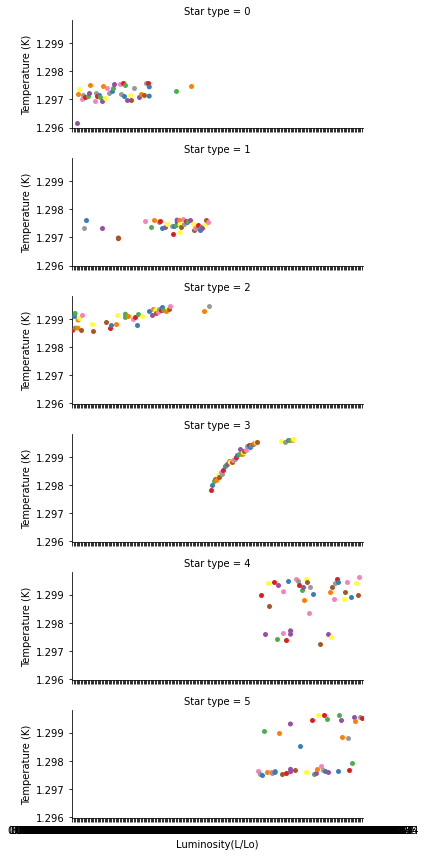

In [31]:
#("Temperature (K)", data("Luminosity(L/Lo)") comparar
sns.stripplot (x = 'Luminosity(L/Lo)', y = 'Temperature (K)', data = data, palette = 'Set3',)
sns.relplot(x='Luminosity(L/Lo)', y='Temperature (K)', data=data, hue= "Star type",
kind='line', height=4, aspect=2, palette='Set2')
comparativa = data.groupby(['Luminosity(L/Lo)'])['Temperature (K)']
sns.catplot(x = 'Luminosity(L/Lo)', y = 'Temperature (K)',
row="Star type",
data=data,
orient="v", height=2, aspect=3, palette="Set1",
)

Codificamos además la única variable categórica que queda entre las variables de entrada, *Star color*. Primero, comprobamos los valores que toma la variable y comprobamos que hay varios repetidos con mayúsculas-minúsculas o con guión:

In [33]:
#Observamos los valores que toma la variable
list(set(data['Star color']))

['Blue',
 'White-Yellow',
 'Whitish',
 'Blue-white',
 'Orange-Red',
 'Blue white ',
 'yellow-white',
 'Orange',
 'White',
 'Blue-White',
 'Red',
 'Yellowish White',
 'white',
 'Blue White',
 'yellowish',
 'Pale yellow orange',
 'Blue ',
 'Blue white',
 'Yellowish']

Eliminamos los guiones y los sustituímos por espacios simples, ponemos todas las letras minúsculas y quitamos los espacios finales para eliminar esta patología:

In [34]:
data.loc[:,'Star color'] = data.loc[:,'Star color'].replace('-', ' ').str.rstrip().str.lower()

Ahora sí, codificamos la variable:

In [36]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder().fit(data[['Star color']])
enc_data = pd.DataFrame(encoder.transform(data[['Star color']]).toarray(), columns = encoder.categories_[0].tolist())
data = pd.concat([data, enc_data], axis = 1)
data = data.drop(['Star color'], axis = 1)